<a href="https://colab.research.google.com/github/sdgroeve/ML-course-VIB-2020/blob/master/Gene_expression_DT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Histone modifications

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

random_seed = 123
np.random.seed(random_seed)

# 1. Reading the data

In [69]:
import pandas as pd

train = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/ML-course-VIB-2020/master/data_train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/ML-course-VIB-2020/master/data_test.csv")

In [70]:
train_ids = train.pop("GeneId")
train_labels = train.pop("Label")

In [71]:
test_index_col = test.pop("GeneId")

# 2. Fitting a decision tree model

The scikit-learn `DecisionTreeClassifier` class computes a decision tree predictive model from a dataset. 

To get all the options for learning you can simply type: 

In [72]:
from sklearn.tree import DecisionTreeClassifier
help(DecisionTreeClassifier)

Help on class DecisionTreeClassifier in module sklearn.tree._classes:

class DecisionTreeClassifier(sklearn.base.ClassifierMixin, BaseDecisionTree)
 |  A decision tree classifier.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : {"gini", "entropy"}, default="gini"
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |  
 |  splitter : {"best", "random"}, default="best"
 |      The strategy used to choose the split at each node. Supported
 |      strategies are "best" to choose the best split and "random" to choose
 |      the best random split.
 |  
 |  max_depth : int, default=None
 |      The maximum depth of the tree. If None, then nodes are expanded until
 |      all leaves are pure or until all leaves contain less than
 |      min_samples_split samples.
 |  
 |  min_samples_split : int or float, default=2
 |      The minimum 

You notice that there are many (hyper)parameters to set. These influence the complexity of the model. An important such parameter is the `max_depth` that sets a limit on how deep a decision tree can become. 

Let's create a decision tree model with `max_depth=3`:

In [73]:
cls = DecisionTreeClassifier(max_depth=3)

This creates a decision tree model with default values for the other hyperparameters:

In [74]:
cls

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Let's create a validation set, fit the model and evaluate.

In [75]:
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(train,train_labels,
                                                  test_size=.2, random_state=random_seed)

cls.fit(train_X,train_y)

predictions_train = cls.predict(train_X)
predictions_val = cls.predict(val_X)

print("Accuracy: (%f) %f"%(accuracy_score(predictions_train, train_y),accuracy_score(predictions_val, val_y)))

predictions_train_prob = cls.predict_proba(train_X)
predictions_val_prob = cls.predict_proba(val_X)

print("Log-loss: (%f) %f"%(log_loss(train_y,predictions_train_prob[:,-1]),log_loss(val_y,predictions_val_prob[:,-1])))

Accuracy: (0.822353) 0.818008
Log-loss: (0.456446) 0.461147


The following code plots the fitted decision tree `cls` as a `tree.png` file:

In [76]:
"""
from sklearn import tree
from io import StringIO
from IPython.display import Image, display
import pydotplus

out = StringIO()
tree.export_graphviz(cls_DT, out_file=out)
graph=pydotplus.graph_from_dot_data(out.getvalue())
graph.write_png("tree.png")
"""

'\nfrom sklearn import tree\nfrom io import StringIO\nfrom IPython.display import Image, display\nimport pydotplus\n\nout = StringIO()\ntree.export_graphviz(cls_DT, out_file=out)\ngraph=pydotplus.graph_from_dot_data(out.getvalue())\ngraph.write_png("tree.png")\n'

How do other values for for the `max_depth` hyperparameter perform?

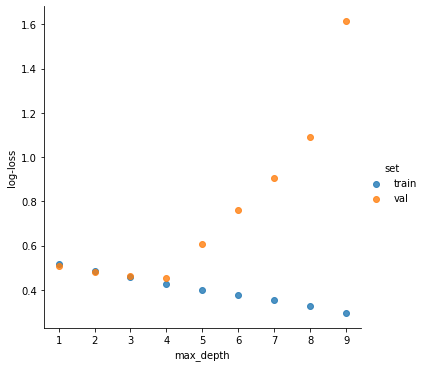

In [77]:
import seaborn as sns

result = []
for md in range(1,10):
  cls = DecisionTreeClassifier(max_depth=md)
  cls.fit(train_X,train_y)
  predictions_train_prob = cls.predict_proba(train_X)
  predictions_val_prob = cls.predict_proba(val_X)
  result.append([md,log_loss(train_y,predictions_train_prob[:,-1]),"train"])
  result.append([md,log_loss(val_y,predictions_val_prob[:,-1]),"val"])

toplot = pd.DataFrame(result,columns=["max_depth","log-loss","set"])
sns.lmplot(x="max_depth",y="log-loss",hue="set",data=toplot,fit_reg=False)

In [78]:
cls = DecisionTreeClassifier(max_depth=14)

predictions_list = []
for i in range(10):
  train_X, val_X, train_y, val_y = train_test_split(train,train_labels,
                                                    test_size=.2, random_state=i)

  cls.fit(train_X,train_y)
  predictions_val = cls.predict(val_X)
  predictions_val_prob = cls.predict_proba(val_X)
  predictions_list.append(list(predictions_val_prob[:,-1]))
  print("%f %f"%(log_loss(val_y,predictions_val_prob[:,-1]),accuracy_score(val_y,predictions_val)))

3.895006 0.806034
4.120590 0.806992
3.977388 0.807471
4.088097 0.804119
4.457159 0.799330
4.285888 0.795977
4.352219 0.805077
4.112998 0.806992
4.423003 0.806992
4.622557 0.793103


In [79]:
tmp = pd.DataFrame(predictions_list)
predictions_avg = tmp.mean(axis=0)
print("Avg. model: %f"%(log_loss(val_y,predictions_avg)))

Avg. model: 0.688091


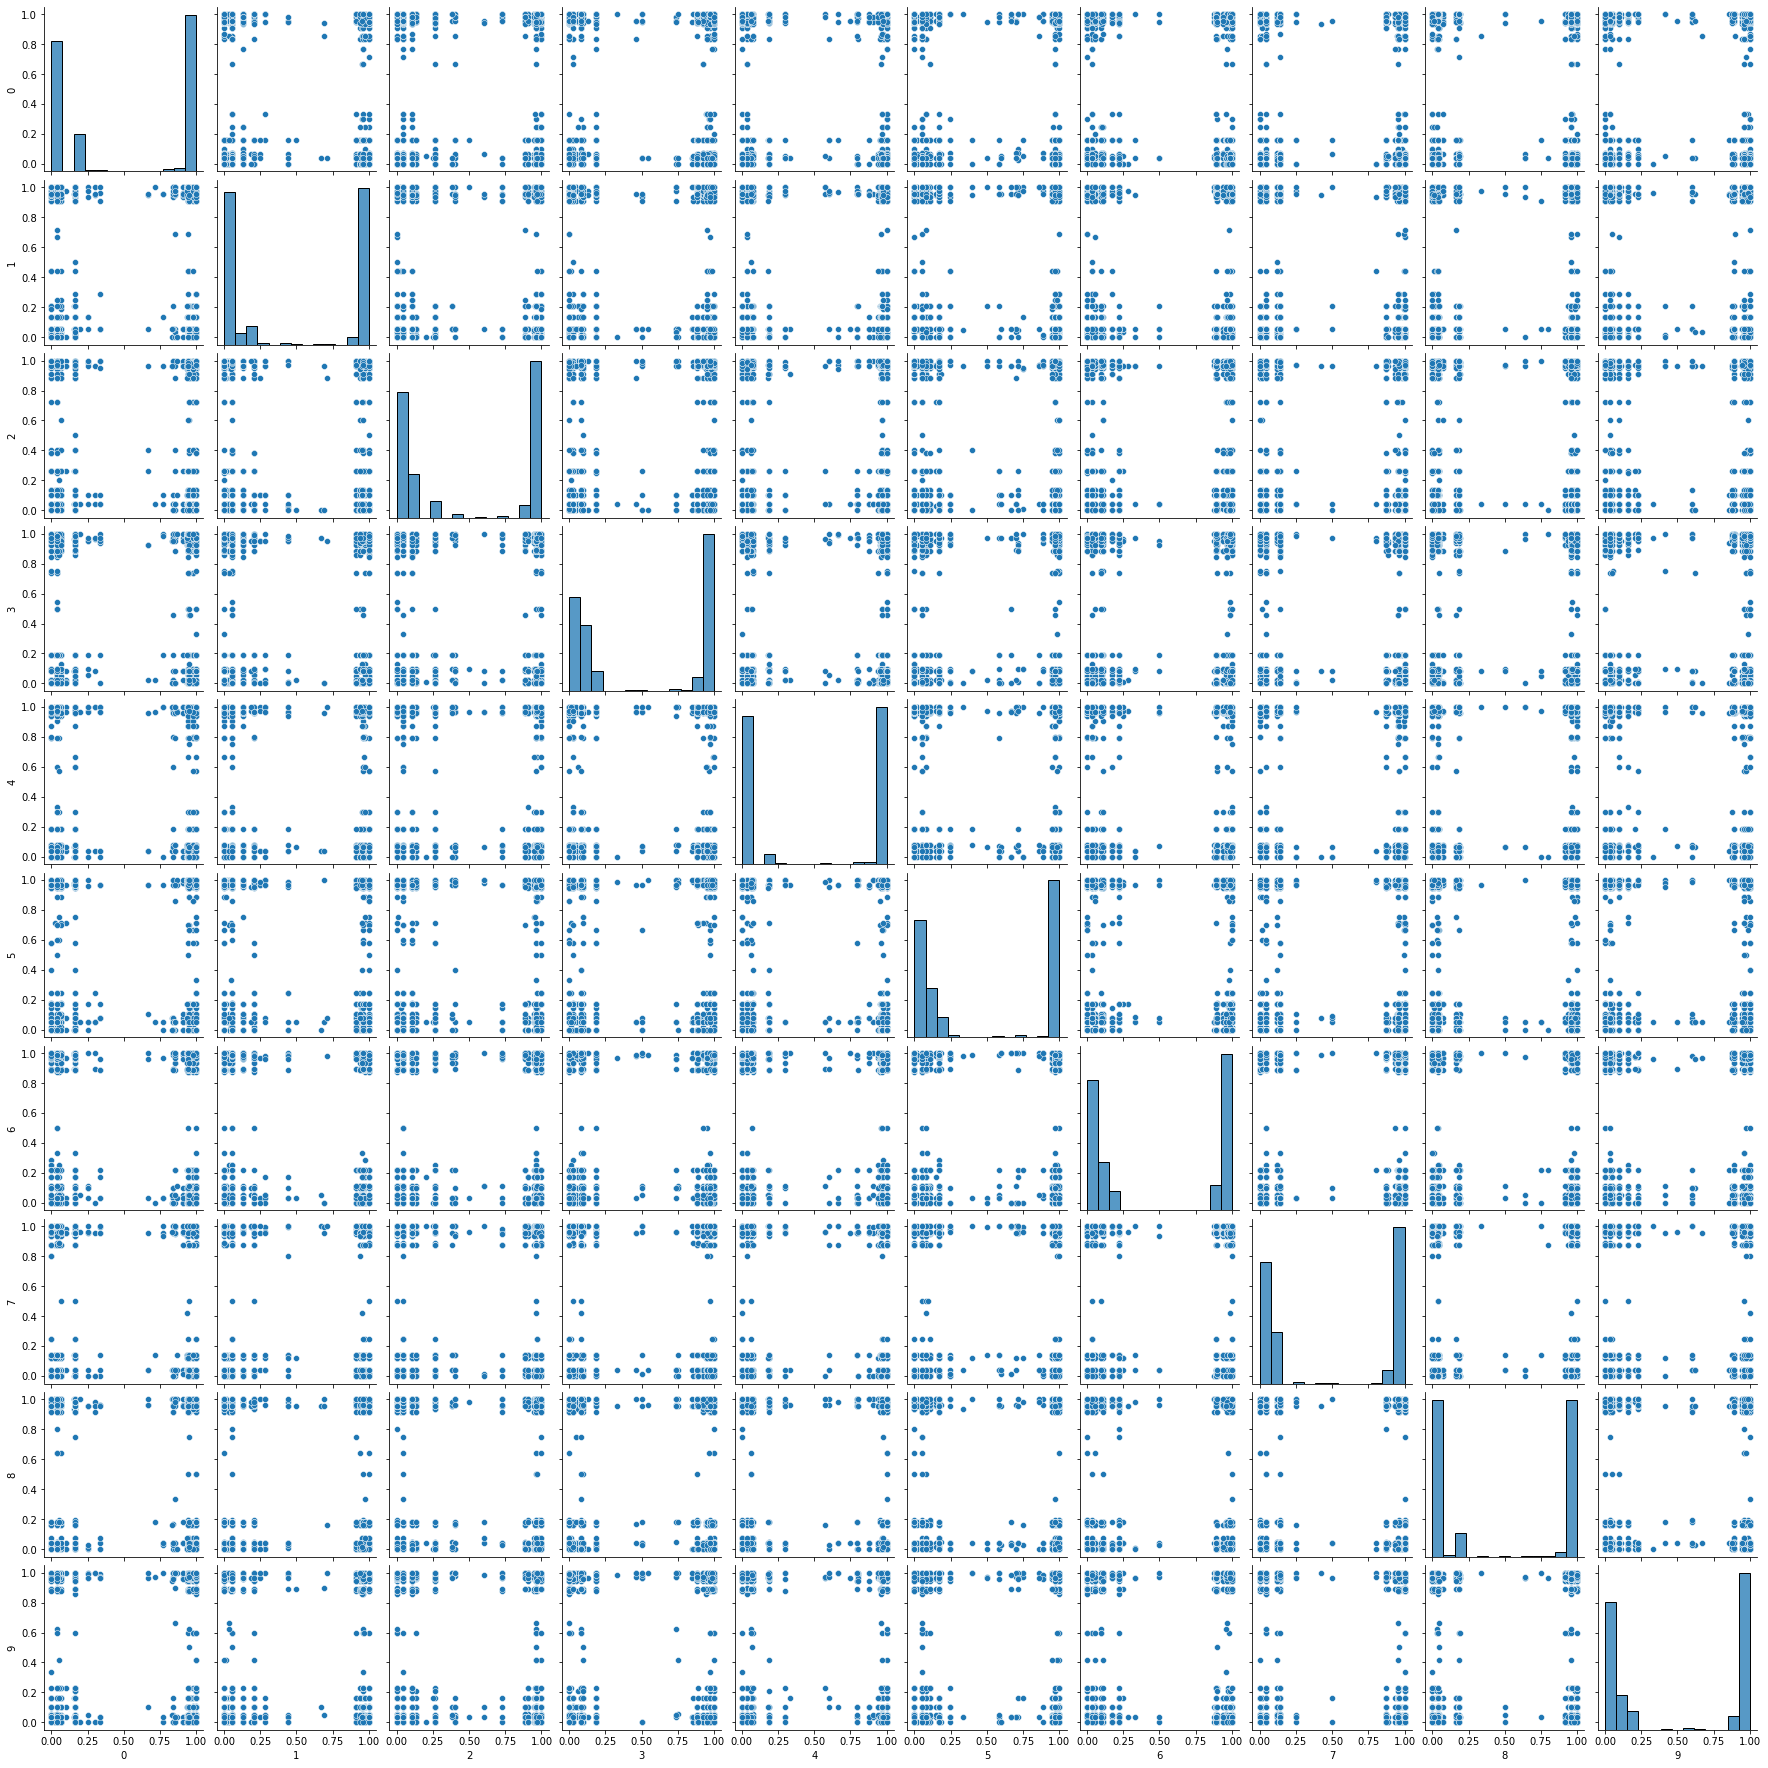

In [80]:

#pd.plotting.scatter_matrix(tmp.transpose())
sns.pairplot(tmp.transpose(),kind="scatter")

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

scaler_minmax = preprocessing.MinMaxScaler()
scaler_minmax.fit(train)
train_norm = pd.DataFrame(scaler_minmax.transform(train),columns=train.columns)

#cls = DecisionTreeClassifier(max_depth=4)
cls = LogisticRegression(C=0.5)

predictions_list = []
for i in range(10):
  train_X, val_X, train_y, val_y = train_test_split(train_norm,train_labels,
                                                    test_size=.2, random_state=i)

  cls.fit(train_X,train_y)
  predictions_val = cls.predict(val_X)
  predictions_val_prob = cls.predict_proba(val_X)
  predictions_list.append(list(predictions_val_prob[:,-1]))
  print("%f %f"%(log_loss(val_y,predictions_val_prob[:,-1]),accuracy_score(val_y,predictions_val)))

0.379115 0.846264
0.362232 0.865900
0.369667 0.865421
0.368026 0.852490
0.397805 0.842433
0.365491 0.865421
0.372490 0.853927
0.376594 0.849617
0.367511 0.857280
0.371391 0.851533


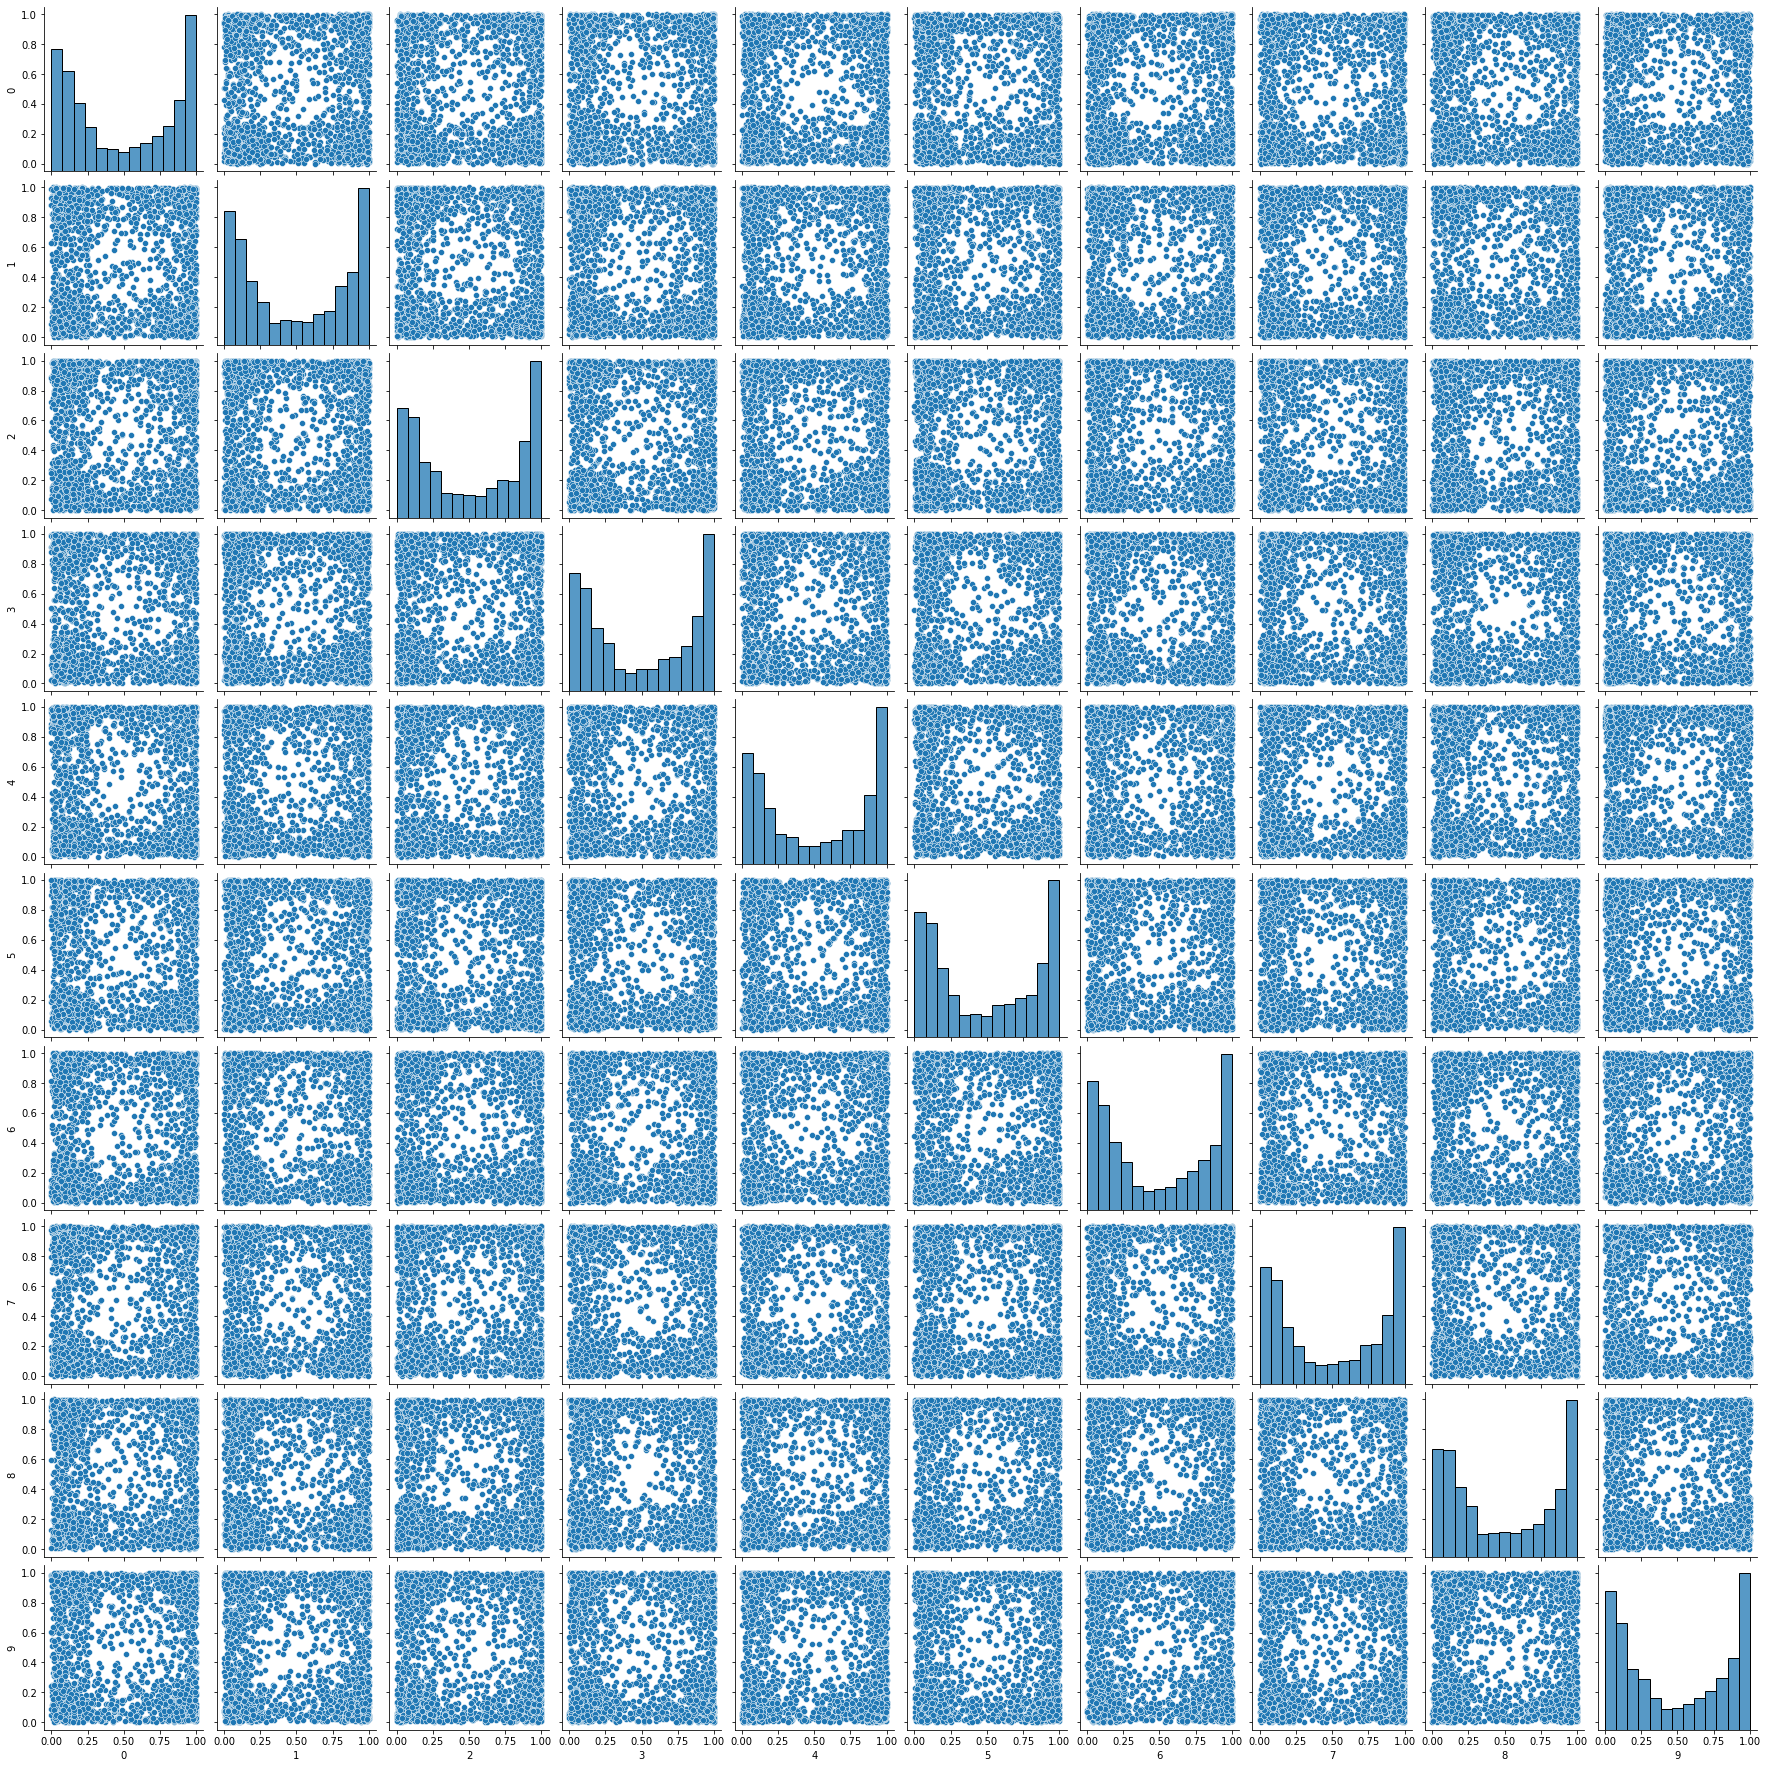

In [82]:
tmp = pd.DataFrame(predictions_list)
#pd.plotting.scatter_matrix(tmp.transpose())
sns.pairplot(tmp.transpose(),kind="scatter")

In [83]:
predictions_avg = tmp.mean(axis=0)
print("Avg. model: %f"%(log_loss(val_y,predictions_avg)))

Avg. model: 0.668163


# 5. Hyperparamters

For our first submission we set the hyperparameter `max_depth=3`. Other values might result in lower log-loss on the testset. 

Since we don't have the testset labels we can only check this on the public leaderboard, which we can/should not do!

So, we need to create our own testset (**not seen during training!**) with known class labels.

Scikit-learn offers many options to do this. One of them is the `train_test_split` function:

In [84]:
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(train_norm,train_labels,
                                                  test_size=.2, random_state=random_seed)

#train fold
print(train_X.shape)
print(train_y.shape)
#validation fold
print(val_X.shape)
print(val_y.shape)

(8348, 500)
(8348,)
(2088, 500)
(2088,)


Fit a decision tree model with `max_depth=14` default paramters on the `train_X` data set.

In [85]:
#solution
cls_DT = DecisionTreeClassifier(max_depth=14)
cls_DT.fit(train_X,train_y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=14, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

What is the accuracy and log-loss on `train_X`? 

In [86]:
#solution
predictions = cls_DT.predict(train_X)
print("Accuracy: %f"%(accuracy_score(predictions, train_y)))
predictions = cls_DT.predict_proba(train_X)
print("Log-loss: %f"%(log_loss(train_y,predictions[:,1])))

Accuracy: 0.954720
Log-loss: 0.153316


What is the accuracy and log-loss on `val_X`?

In [87]:
#solution
predictions = cls_DT.predict(val_X)
print("Accuracy: %f"%(accuracy_score(predictions, val_y)))
predictions = cls_DT.predict_proba(val_X)
print("Log-loss: %f"%(log_loss(val_y,predictions[:,1])))

Accuracy: 0.803161
Log-loss: 4.537388


What do you see?


The following code evaluates different values for this hyperparameter.

In [88]:
for maxdepth in range(1,20,1):
    cls = DecisionTreeClassifier(max_depth=maxdepth)
    cls.fit(train_X,train_y)
    predictions_train = cls.predict(train_X)
    predictions_val = cls.predict(val_X)
    predictions_train_prob = cls.predict_proba(train_X)[:,1]
    predictions_val_prob = cls.predict_proba(val_X)[:,1]
    print("%i (%f) %f (%f) %f"%(maxdepth,
                                accuracy_score(predictions_train, train_y),accuracy_score(predictions_val, val_y),
                                log_loss(train_y,predictions_train_prob),log_loss(val_y,predictions_val_prob)))

1 (0.787254) 0.795019 (0.517571) 0.507348
2 (0.810134) 0.811782 (0.484475) 0.479824
3 (0.822353) 0.818008 (0.456446) 0.461147
4 (0.825587) 0.818487 (0.427133) 0.456196
5 (0.840920) 0.820402 (0.401390) 0.589821
6 (0.851461) 0.826149 (0.378663) 0.762900
7 (0.864998) 0.824713 (0.356115) 0.919243
8 (0.878654) 0.826628 (0.327576) 1.079069
9 (0.894586) 0.817050 (0.292468) 1.554587
10 (0.910877) 0.810824 (0.258722) 2.038432
11 (0.924413) 0.811782 (0.225339) 2.769391
12 (0.938908) 0.811782 (0.193549) 3.448603
13 (0.946574) 0.810824 (0.173513) 3.833844
14 (0.955079) 0.808908 (0.150152) 4.429127
15 (0.960350) 0.811782 (0.140287) 4.475136
16 (0.963225) 0.801724 (0.128579) 4.983484
17 (0.967298) 0.802682 (0.114611) 5.409465
18 (0.969334) 0.801724 (0.110653) 5.292145
19 (0.971131) 0.799808 (0.103157) 5.438835


What do you see?

So, we have split the data into a train- and validationset. We can of course split the data in many different ways (different random seeds) resulting in different train- and validationsets.

Let's try 5 different random seeds:

In [89]:
for run in range(5):
  train_X, val_X, train_y, val_y = train_test_split(train_norm,train_labels,
                                                  test_size=.8, random_state=run)
  min_m = 100
  best = None
  for maxdepth in range(1,20,1):
      cls = DecisionTreeClassifier(max_depth=maxdepth)
      cls.fit(train_X,train_y)
      predictions_val_prob = cls.predict_proba(val_X)[:,1]
      m = log_loss(val_y,predictions_val_prob)
      if m < min_m:
        min_m = m
        best = maxdepth
  print("%i %f"%(best,min_m))

2 0.489871
2 0.501669
3 0.477714
2 0.491435
3 0.479280


What do you see?

The solution is to run several train-validations splits and average the performance.

One popular method is cross-validation that uses each datapoint once as a testpoint.

It works as follows:
<br/>
<br/>
<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png"/>
<br/>
<br/>

It is easy to run this in Scikit-learn:



In [90]:
from sklearn.model_selection import cross_val_predict

for maxdepth in range(1,10,1):
    cls = DecisionTreeClassifier(max_depth=maxdepth)
    predictions = cross_val_predict(cls,train_norm,train_labels,
                                    cv=10,
                                    method="predict_proba")
    print("%i %f"%(maxdepth,log_loss(train_labels,predictions[:,1])))

1 0.518693
2 0.488489
3 0.469868
4 0.458348
5 0.509179
6 0.627307
7 0.861075
8 1.153489
9 1.526412


We can do this in two lines of code with the `GridSearchCV` module:


In [91]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth':range(1,10)
    }

GSCV = GridSearchCV(cls_DT, params,
                    cv=10,
                    scoring="neg_log_loss",
                    verbose=1).fit(train_norm,train_labels)

print(GSCV.best_estimator_)
print(GSCV.best_score_)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.0min finished


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
-0.45834668307446147


Play with the hyperparameters in a Template notebook and make some Kaggle submissions.

# 5. Ensemble learning: bagging

We have seen that bias and variance play an important role in Machine Learning. 

Let's first see what bagging can do for our dataset. 

In [92]:
from sklearn.ensemble import BaggingClassifier

cls = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=4),random_state=random_seed)
                                                            
cls.fit(train_X,train_y)
predictions_train = cls.predict(train_X)
predictions_val = cls.predict(val_X)
print("Accuracy: (%f) %f"%(accuracy_score(predictions_train, train_y),accuracy_score(predictions_val, val_y)))
predictions_train_prob = cls.predict_proba(train_X)
predictions_val_prob = cls.predict_proba(val_X)
print("Log-loss: (%f) %f"%(log_loss(train_y,predictions_train_prob[:,1]),log_loss(val_y,predictions_val_prob[:,1])))

Accuracy: (0.856732) 0.832794
Log-loss: (0.348320) 0.410271


With the `RandomForestClassifier` the variance of the decision tree is reduced also by selecting features for decision tree contruction at random. Let's see how far we get with default hyperparameter values.   

In [93]:
from sklearn.ensemble import RandomForestClassifier

cls = RandomForestClassifier(random_state=random_seed)

cls.fit(train_X,train_y)
predictions_train = cls.predict(train_X)
predictions_val = cls.predict(val_X)
print("Accuracy: (%f) %f"%(accuracy_score(predictions_train, train_y),accuracy_score(predictions_val, val_y)))
predictions_train_prob = cls.predict_proba(train_X)
predictions_val_prob = cls.predict_proba(val_X)
print("Log-loss: (%f) %f"%(log_loss(train_y,predictions_train_prob[:,1]),log_loss(val_y,predictions_val_prob[:,1])))

Accuracy: (1.000000) 0.852917
Log-loss: (0.101239) 0.409509


# 6. Ensemble learning: boosting

How about the `GradientBoostingClassifier`?

In [94]:
#solution
from sklearn.ensemble import GradientBoostingClassifier

cls = GradientBoostingClassifier(random_state=random_seed,
                                    max_depth=10)
cls.fit(train_X,train_y)
predictions_train = cls.predict(train_X)
predictions_val = cls.predict(val_X)
print("Accuracy: (%f) %f"%(accuracy_score(predictions_train, train_y),accuracy_score(predictions_val, val_y)))
predictions_train_prob = cls.predict_proba(train_X)
predictions_val_prob = cls.predict_proba(val_X)
print("Log-loss: (%f) %f"%(log_loss(train_y,predictions_train_prob[:,1]),log_loss(val_y,predictions_val_prob[:,1])))

Accuracy: (1.000000) 0.851839
Log-loss: (0.000345) 0.628098
